## 1. Setup and Data Loading

In [18]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# --- Constants ---
TRIP_FILE_PATH = "C:/Users/user/PTV_Intern/data/raw/NHTS_US_2017/trippub.csv"
OUTPUT_CHAIN_PATH = "C:/Users/user/PTV_Intern/src/DeepAM/dataset/activity_chain.npy"
OUTPUT_IDS_PATH = "C:/Users/user/PTV_Intern/src/DeepAM/dataset/person_ids.csv"
OUTPUT_W_PATH = "C:/Users/user/PTV_Intern/src/DeepAM/dataset/chain_weights.npy"
MAX_LEN = 15 # Maximum number of activities in a chain

# --- Activity Mapping ---
# Maps WHYTO codes to a smaller set of activity categories
ACTIVITY_MAP = {
    -9: 14, -8: 14, -7: 14, 5: 14, 7: 14, 97: 14, # Not ascertained / Other
    1: 1,  # Home
    2: 2, 3: 2, 4: 2, # Work / School
    6: 15, # Accompanying someone
    8: 3,  # Shopping
    9: 4, 10: 4, # Social/Recreational
    11: 5, # Family/Personal Business
    12: 6, # Meals
    13: 7, # Transport someone
    14: 8, # Medical/Dental
    15: 9, # Religious/Community
    16: 10, # Errands
    17: 11, # Exercise
    18: 12, # Hobbies
    19: 13, # Change of transport
}

EOS_ACTIVITY_TYPE = 0 # End-of-sequence token
HOME_ACTIVITY_TYPE = 1 # Home activity type

trip_df = pd.read_csv(TRIP_FILE_PATH)

## 2. Preprocessing

In [19]:
def time_to_minutes(t):
    # Converts HHMM time to minutes from midnight
    if pd.isna(t) or not str(t).replace('.', '', 1).isdigit():
        return np.nan
    t = int(float(t))
    if not 0 <= t <= 2359:
        return np.nan
    hour = t // 100
    minute = t % 100
    return hour * 60 + minute

# Create a copy to avoid SettingWithCopyWarning
proc_df = trip_df[['HOUSEID', 'PERSONID', 'WHYFROM', 'WHYTO', 'STRTTIME', 'ENDTIME']].copy()

# Convert times to minutes
proc_df['DEPART_MINUTES'] = proc_df['STRTTIME'].apply(time_to_minutes)
proc_df['ARRIVE_MINUTES'] = proc_df['ENDTIME'].apply(time_to_minutes)

# Drop rows with invalid time entries
proc_df.dropna(subset=['DEPART_MINUTES', 'ARRIVE_MINUTES'], inplace=True)

# Convert minutes to 15-minute intervals (0 to 95)
proc_df['DEPART_INTERVAL'] = (proc_df['DEPART_MINUTES'] // 15)
proc_df['ARRIVE_INTERVAL'] = (proc_df['ARRIVE_MINUTES'] // 15)

# Map activity codes
proc_df['WHYFROM_CODE'] = proc_df['WHYFROM'].map(ACTIVITY_MAP).fillna(14).astype(int) # Default to 'Other'
proc_df['WHYTO_CODE'] = proc_df['WHYTO'].map(ACTIVITY_MAP).fillna(14).astype(int)     # Default to 'Other'

# Remove overnight trips
proc_df = proc_df[proc_df['DEPART_MINUTES']<=proc_df['ARRIVE_MINUTES']]

# Sort trips chronologically for each person
proc_df = proc_df.sort_values(by=['HOUSEID', 'PERSONID', 'DEPART_MINUTES']).reset_index(drop=True)

print(f"Processed {len(proc_df)} valid trips.")
proc_df.head()

Processed 922097 valid trips.


,HOUSEID,PERSONID,WHYFROM,WHYTO,STRTTIME,ENDTIME,DEPART_MINUTES,ARRIVE_MINUTES,DEPART_INTERVAL,ARRIVE_INTERVAL,WHYFROM_CODE,WHYTO_CODE
0,30000007,1,1,19,1000,1015,600,615,40,41,1,13
1,30000007,1,19,1,1510,1530,910,930,60,62,13,1
2,30000007,2,3,1,700,900,420,540,28,36,2,1
3,30000007,2,1,3,1800,2030,1080,1230,72,82,1,2
4,30000007,3,1,8,845,900,525,540,35,36,1,3


## 3. Activity Chain Generation (Corrected Logic)
This logic first generates a raw list of activities based on stops, then merges consecutive activities of the same type.

In [20]:
all_final_chains = []
grouped = proc_df.groupby(['HOUSEID', 'PERSONID'])
invalid_cnt = {'broken': 0, 'overlap': 0}

for (houseid, personid), person_trips in tqdm(grouped, desc="Generating Activity Chains"):
    if person_trips.empty:
        continue

    # 1. Generate RAW activities from trips
    raw_activities = []
    first_trip = person_trips.iloc[0]
    
    # Add initial home activity
    raw_activities.append({
        'type': first_trip['WHYFROM_CODE'],
        'start': 1,
        'end': first_trip['DEPART_INTERVAL']
    })

    # Add activities between trips
    for i in range(len(person_trips)-1):
        current_trip = person_trips.iloc[i]
        next_trip = person_trips.iloc[i+1]
        raw_activities.append({
            'type': current_trip['WHYTO_CODE'],
            'start': current_trip['ARRIVE_INTERVAL'],
            'end': next_trip['DEPART_INTERVAL']
        })

        # Remove invalid chains
        if current_trip['WHYTO_CODE'] != next_trip['WHYFROM_CODE']:
            if current_trip['WHYFROM_CODE'] != next_trip['WHYFROM_CODE'] or current_trip['WHYTO_CODE'] != next_trip['WHYTO_CODE']:
                raw_activities = []
                invalid_cnt['broken'] += 1
                break
        if current_trip['ARRIVE_INTERVAL'] > next_trip['DEPART_INTERVAL']:
            raw_activities = []
            invalid_cnt['overlap'] += 1
            break
                
    if not raw_activities:
        continue

    # Add final activity
    last_trip = person_trips.iloc[-1]
    # midnight-cross case
    raw_activities.append({
        'type': last_trip['WHYTO_CODE'],
        'start': last_trip['ARRIVE_INTERVAL'],
        'end': 95 # End of day
    })

    # 2. Merge consecutive activities of the same type
    merged_activities = [raw_activities[0]]
    for i in range(1, len(raw_activities)):
        current_act = raw_activities[i]
        last_merged_act = merged_activities[-1]

        # If type is the same, merge by updating the end time of the last merged activity
        if current_act['type'] == last_merged_act['type']:
            last_merged_act['end'] = current_act['end']
        else:
            merged_activities.append(current_act)

    # 3. Store the final merged chain
    if merged_activities:
        all_final_chains.append({
            'houseid': houseid,
            'personid': personid,
            'activities': merged_activities
        })

print(f"Generated {len(all_final_chains)} final merged activity chains.")

Generating Activity Chains:   0%|          | 0/219141 [00:00<?, ?it/s]

Generated 218775 final merged activity chains.


## 4. Filtering, Padding, and Saving

In [21]:
person_identifiers = []
processed_chains_list = []
len_chains = []

for chain_data in tqdm(all_final_chains, desc="Filtering and Padding"):
    activities = chain_data['activities']
    
    # Filter out chains that are too long (before adding EOS)
    if len(activities) >= MAX_LEN:
        continue
        
    person_identifiers.append((chain_data['houseid'], chain_data['personid']))
    
    # [type, start, end, length, duration]
    chain_array = np.zeros((MAX_LEN, 5), dtype=np.int32)
    chain_len = len(activities)
    len_chains.append(chain_len)
    
    for i, act in enumerate(activities):
        duration = act['end'] - act['start']
        if duration < 0: duration += 96 # Handle overnight activities
        
        chain_array[i, 0] = act['type']
        chain_array[i, 1] = act['start']
        chain_array[i, 2] = act['end']
        chain_array[i, 3] = chain_len - 1   # Convert to 0-based idx
        chain_array[i, 4] = duration
        
    # Add EOS token
    last_activity_end = activities[-1]['end'] if activities else 1
    chain_array[chain_len, 0] = EOS_ACTIVITY_TYPE
    chain_array[chain_len, 1] = last_activity_end
    chain_array[chain_len, 2] = last_activity_end
    chain_array[chain_len, 3] = chain_len - 1  # Convert to 0-based idx
    chain_array[chain_len, 4] = 0 # Duration is 0 for EOS
    
    processed_chains_list.append(chain_array)

# Convert list to a single numpy array
final_chains_array = np.array(processed_chains_list, dtype=np.int32)

# # Convert 1-based categories to 0-based categories by deducting 1
# final_chains_array = final_chains_array - 1

# Save the processed chains
np.save(OUTPUT_CHAIN_PATH, final_chains_array)
print(f'Shape of the final numpy array: {final_chains_array.shape}')
print(f'Saved the final numpy array to {OUTPUT_CHAIN_PATH}')

# Save the person identifiers
person_df = pd.DataFrame(person_identifiers, columns=['HOUSEID', 'PERSONID'])
person_df.to_csv(OUTPUT_IDS_PATH, index_label='person_index')
print(f'Saved the person identifiers to {OUTPUT_IDS_PATH}')

Filtering and Padding:   0%|          | 0/218775 [00:00<?, ?it/s]

Shape of the final numpy array: (218502, 15, 5)
Saved the final numpy array to C:/Users/user/PTV_Intern/src/DeepAM/dataset/activity_chain.npy
Saved the person identifiers to C:/Users/user/PTV_Intern/src/DeepAM/dataset/person_ids.csv


In [30]:
activity_chains = final_chains_array
ACTIVITY_CHAIN_VOCAB = []
for i in range(activity_chains.shape[-1]):
    # print(activity_chains[:,:,i].max())
    ACTIVITY_CHAIN_VOCAB.append(activity_chains[:,:,i].max()+1)
ACTIVITY_CHAIN_VOCAB

[np.int32(16), np.int32(96), np.int32(96), np.int32(14), np.int32(96)]

Text(0, 0.5, 'Frequency')

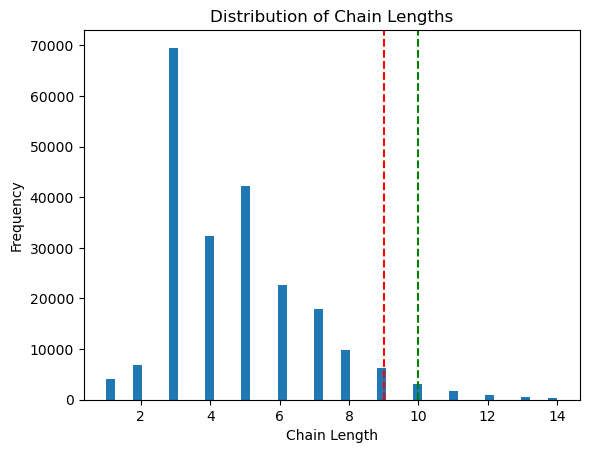

In [22]:
import matplotlib.pyplot as plt
chain_lengths = np.array(len_chains)
max_len = int(np.percentile(chain_lengths, 98))  # 예: 98% 이하의 chain은 다 커버

plt.hist(chain_lengths, bins=50)
plt.axvline(np.percentile(chain_lengths, 95), color='r', linestyle='--')
plt.axvline(np.percentile(chain_lengths, 98), color='g', linestyle='--')
plt.title("Distribution of Chain Lengths")
plt.xlabel("Chain Length")
plt.ylabel("Frequency")

## 5. Data Balancing

In [23]:
from ipfn import ipfn

def raking(D_tar, train_df):
    df = train_df.copy()
    df['count'] = 1.0
    total_sum = float(len(df))

    # 1. Create a dense 3D frequency table (contingency table)
    type_cats = sorted(df['mode_type'].unique())
    dur_cats = sorted(df['mode_duration'].unique())
    len_cats = sorted(df['chain_length'].unique())

    table = pd.crosstab(index=df['mode_type'], columns=[df['mode_duration'], df['chain_length']])
    idx = pd.Index(type_cats, name='mode_type')
    cols = pd.MultiIndex.from_product([dur_cats, len_cats], names=['mode_duration', 'chain_length'])
    table = table.reindex(index=idx, columns=cols, fill_value=0)
    base_array = table.values.reshape(len(type_cats), len(dur_cats), len(len_cats))

    # 2. Target marginals (scaled to total count)
    target_type = D_tar['mode_type'].reindex(type_cats, fill_value=0).to_numpy(dtype=float) * total_sum
    target_dur = D_tar['mode_duration'].reindex(dur_cats, fill_value=0).to_numpy(dtype=float) * total_sum
    target_len = D_tar['chain_length'].reindex(len_cats, fill_value=0).to_numpy(dtype=float) * total_sum

    # 3. Define marginals and dimensions for IPF
    aggregates = [target_type, target_dur, target_len]
    dims = [[0], [1], [2]]
    # aggregates = [target_dur, target_type, target_len]
    # dims = [[1], [0], [2]]

    # 4. Run IPF
    ipf = ipfn.ipfn(base_array, aggregates, dims, max_iteration=1000, rate_tolerance=1e-6, convergence_rate=1e-7)
    adjusted = ipf.iteration()

    # 5. Map weights to individuals
    weight_factors = np.divide(adjusted, base_array, out=np.ones_like(adjusted, dtype=float), where=base_array!=0)

    weight_dict = {}
    for i, t in enumerate(type_cats):
        for j, d in enumerate(dur_cats):
            for k, l in enumerate(len_cats):
                weight_dict[(t, d, l)] = weight_factors[i, j, k]

    df['joint_key'] = list(zip(df['mode_type'], df['mode_duration'], df['chain_length']))
    df['weight'] = df['joint_key'].map(weight_dict).fillna(1.0)

    if df['weight'].sum() > 0:
        df['weight'] = df['weight'] * len(df) / df['weight'].sum()
    else:
        df['weight'] = 1.0

    return df['weight'].values


In [24]:
STEPSIZE = 0.1
THRESHOLD = 1
MAXITER = 125
D_ideal = {}
D_tar = {}
diff_log = []

# --- I. Extract features for balancing ---
chain_info = []
for idx, chain in enumerate(final_chains_array):
    types = chain[:, 0]
    durs = chain[:, 4]
    length = np.sum(types != 0)

    inner_types = types[1:length-1]
    inner_durs = durs[1:length-1]

    mode_type = np.bincount(inner_types.astype(int)).argmax() if len(inner_types) > 0 else types[0]
    mode_dur = np.bincount(inner_durs.astype(int)).argmax() if len(inner_durs) > 0 else durs[0]

    chain_info.append([idx, mode_type, mode_dur, length])

chain_info_df = pd.DataFrame(chain_info, columns=['idx', 'mode_type', 'mode_duration', 'chain_length'])

# --- II. Define Target Marginal Distributions ---
for feature in ['mode_type', 'mode_duration', 'chain_length']:
    # 1: Original distribution
    O_i = chain_info_df[feature].value_counts(normalize=True)
    # 2: Ideal (uniform) distribution
    I_i = pd.Series(1.0 / len(O_i), index=O_i.index)
    # 3: Initialize target distribution
    D_ideal[feature] = I_i
    D_tar[feature] = O_i
    
# --- III. Iterative Raking Algorithm ---
weights = np.ones(len(chain_info_df))
# 4: repeat
for iter in tqdm(range(MAXITER), desc='Balancing Data by Raking'):
    D_adj = {}
    # 5: for each feature in target features
    for feature in ['mode_type', 'mode_duration', 'chain_length']:
        T_i = D_tar[feature].copy()
        I_i = D_ideal[feature].copy()
        # 6-7: Calculate the differences between adjusted and target share for each class in feature:
        D_i = T_i - I_i
        # 8-9: Adjust the elements based on its difference and the STEPSIZE
        T_i = T_i - D_i * STEPSIZE
        # 10-12: Ensurre the sum of percentages remains equal to 1 by normalizing the values
        F_i = 1 / sum(T_i)
        T_i = T_i * F_i
        D_tar[feature] = T_i

    # 13-14: Calculate weights for each sample (W) using the ranking algorithm:
    W = raking(D_tar, chain_info_df)
    chain_info_df['weight'] = W
    
    # --- Compute D_adj: weighted empirical distribution ---
    D_adj = {}
    for feature in ['mode_type', 'mode_duration', 'chain_length']:
        adj = chain_info_df.groupby(feature)['weight'].sum()
        adj = adj / adj.sum()
        D_adj[feature] = adj

    # --- Compute L1 norm (total variation) between D_tar and D_adj ---
    total_diff = 0.0
    for feature in ['mode_type', 'mode_duration', 'chain_length']:
        keys = sorted(set(D_ideal[feature].index).union(D_adj[feature].index))
        d_ideal = D_ideal[feature].reindex(keys, fill_value=0)
        d_adj = D_adj[feature].reindex(keys, fill_value=0)
        total_diff += (d_ideal - d_adj).abs().sum()
    diff_log.append(total_diff)
    # --- Termination condition ---
    if total_diff < THRESHOLD:
        print(f"✅ Converged at iteration {iter}, diff = {total_diff:.4f}")
        break
else:
    print(f"⚠️ Raking failed to converge within {MAXITER} iterations. Final diff = {total_diff:.4f}")

Balancing Data by Raking:   0%|          | 0/125 [00:00<?, ?it/s]

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [25]:
# Save the weights
np.save(OUTPUT_W_PATH, W)
print(f'Saved chain weights to {OUTPUT_W_PATH}')

Saved chain weights to C:/Users/user/PTV_Intern/src/DeepAM/dataset/chain_weights.npy


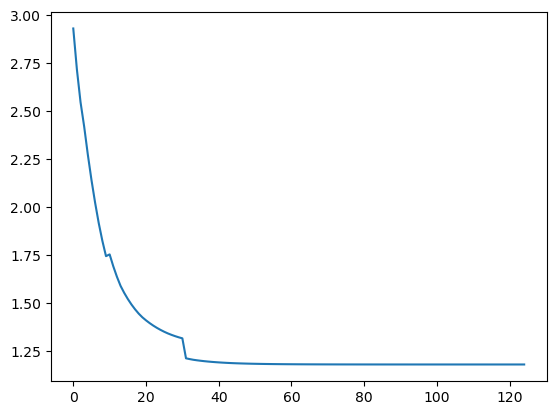

In [26]:
plt.plot(diff_log)

## 6. Visualization of Balancing Effect

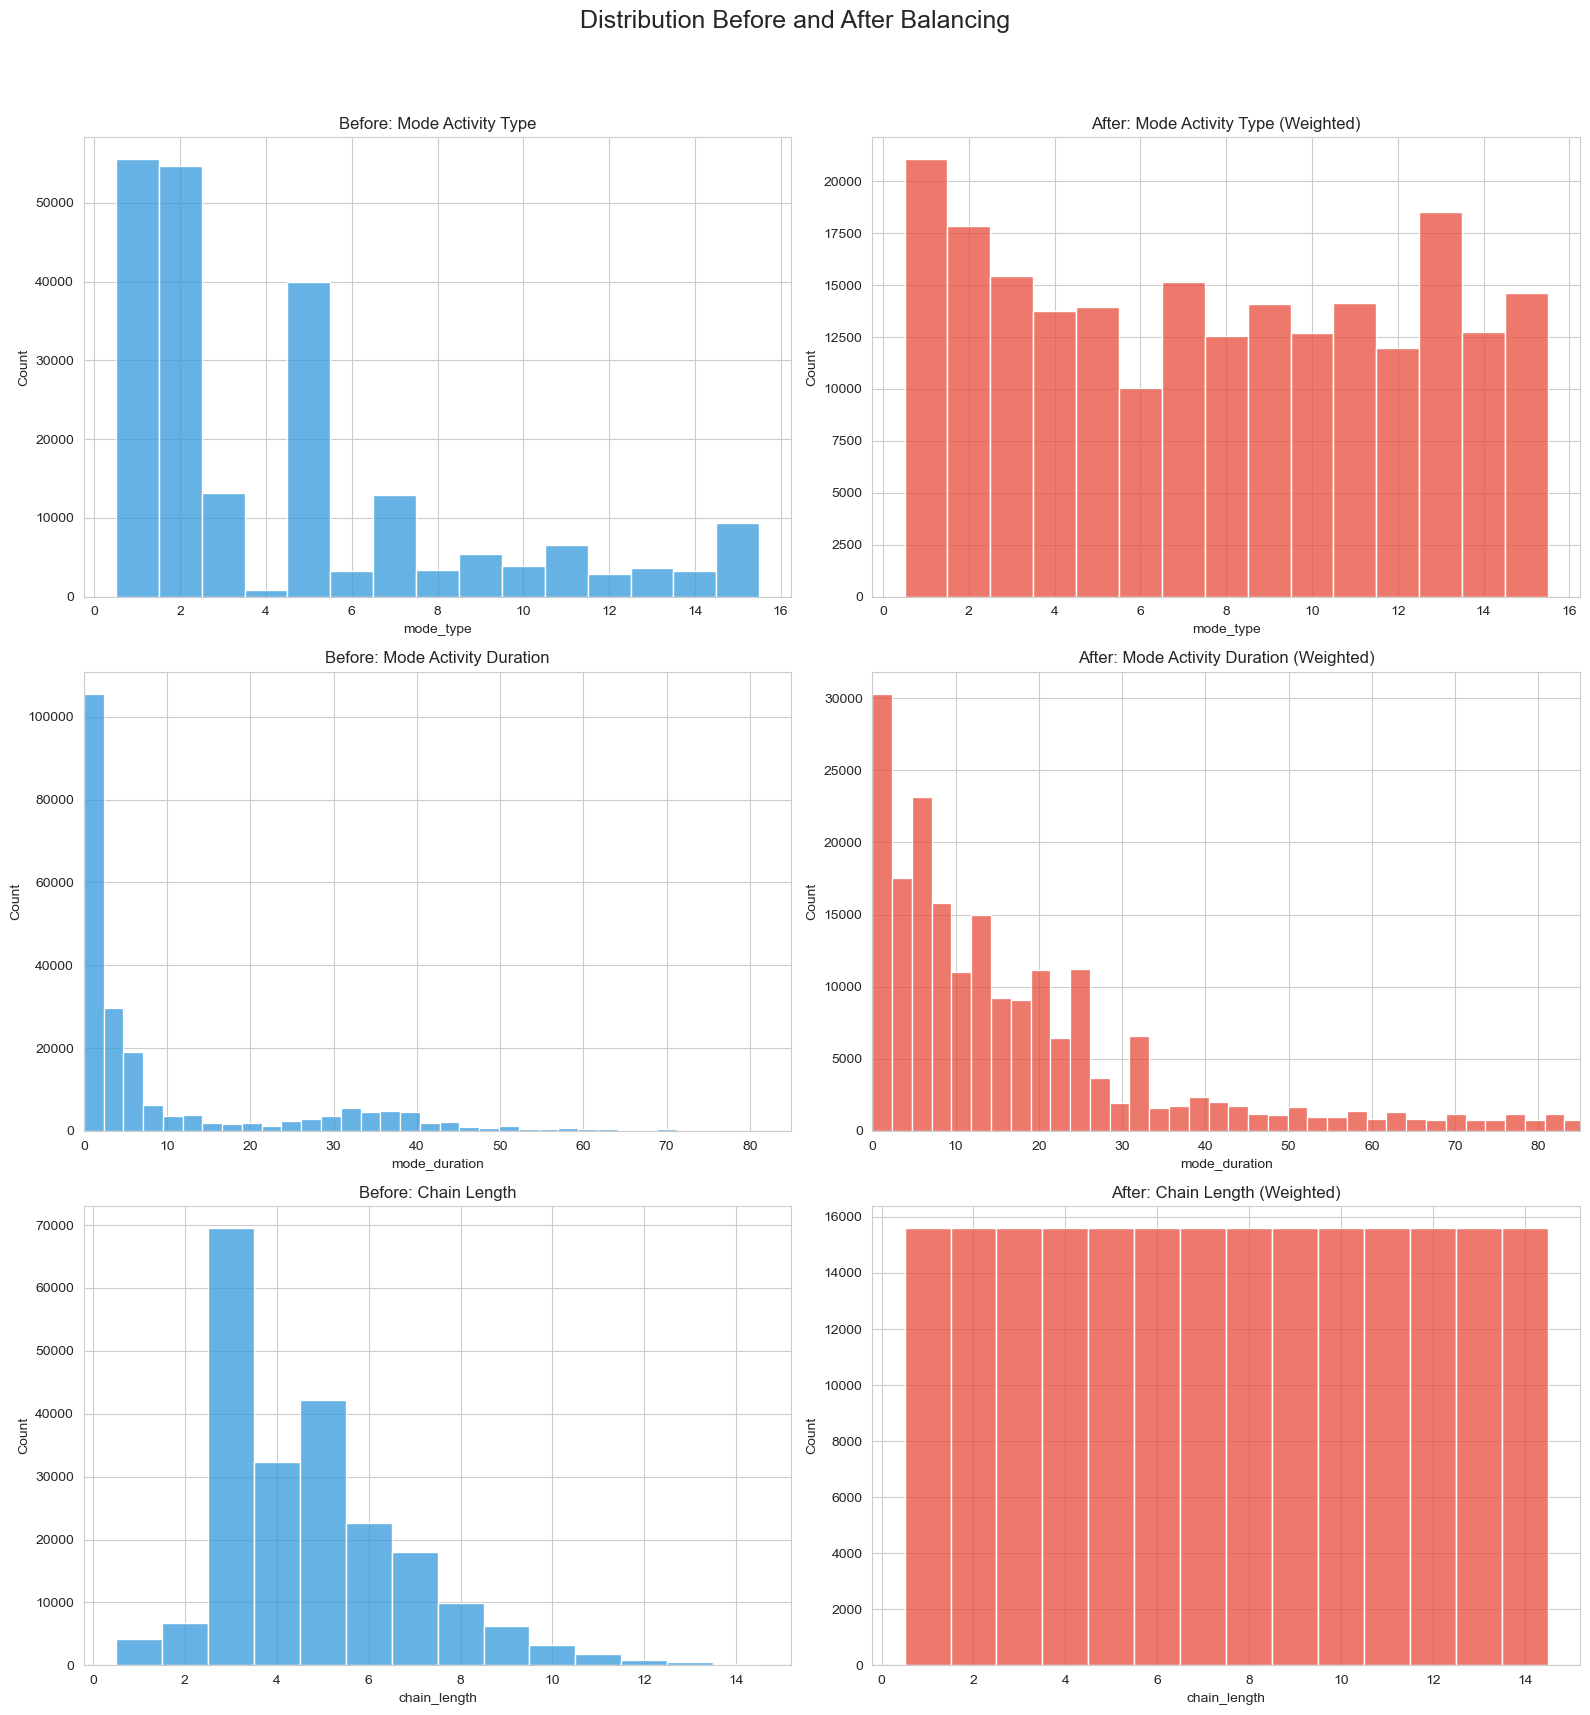

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Distribution Before and After Balancing', fontsize=18)

features_to_plot = ['mode_type', 'mode_duration', 'chain_length']
plot_titles = ['Mode Activity Type', 'Mode Activity Duration', 'Chain Length']

for i, feature in enumerate(features_to_plot):
    # Before
    sns.histplot(data=chain_info_df, x=feature, ax=axes[i, 0], color='#3498db', discrete=feature!='mode_duration', bins=40 if feature=='mode_duration' else None)
    axes[i, 0].set_title(f'Before: {plot_titles[i]}', fontsize=12)
    
    # After
    sns.histplot(data=chain_info_df, x=feature, weights='weight', ax=axes[i, 1], color='#e74c3c', discrete=feature!='mode_duration', bins=40 if feature=='mode_duration' else None)
    axes[i, 1].set_title(f'After: {plot_titles[i]} (Weighted)', fontsize=12)

    # Set x-limit for duration for better visualization
    if feature == 'mode_duration':
        xlim = chain_info_df['mode_duration'].quantile(0.98)
        axes[i, 0].set_xlim(0, xlim)
        axes[i, 1].set_xlim(0, xlim)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()